# Cytocipher on prostate cancer

Using this dataset:
https://www.prostatecellatlas.org/ 

Paper is here:
https://www.sciencedirect.com/science/article/pii/S2211124721016284?via%3Dihub
                              
## INPUT: 

    * Downloaded in notebook to:
    * data/test_data/


## OUTPUT: 

    * None, plots within.
    
# Environment Setup

In [2]:
work_dir = './' # Put as Cytocipher_manuscript/ directory.
import os
os.chdir(work_dir)
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.io import mmread
from collections import defaultdict
import importlib as imp
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib
from scanpy import AnnData

from sklearn.metrics import adjusted_rand_score

import cytocipher as cc
import cytocipher.plotting.cluster_diagnostics as cd

data_dir = 'data/test_data/'

import utils.preprocessing.load_data.simple_pickle as spl
import utils.visualisation.quick_plots as qpl
import utils.visualisation.helpers as vhs

# Downloading/Loading data

In [2]:
!wget https://cellgeni.cog.sanger.ac.uk/prostatecellatlas/prostate_portal_300921.h5ad
!mv prostate_portal_300921.h5ad {data_dir}

--2022-09-26 14:22:28--  https://cellgeni.cog.sanger.ac.uk/prostatecellatlas/prostate_portal_300921.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 193.62.203.61, 193.62.203.62, 193.62.203.63
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|193.62.203.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179425864 (171M) [application/x-hdf]
Saving to: 'prostate_portal_300921.h5ad’

prostate_portal_300 100%[===================>] 171.11M  6.84MB/s    in 27s     

2022-09-26 14:22:58 (6.34 MB/s) - 'prostate_portal_300921.h5ad’ saved [179425864/179425864]



In [2]:
data = sc.read_h5ad(data_dir+'prostate_portal_300921.h5ad')

In [3]:
data.shape

(17108, 33538)

In [4]:
data.obs.keys()

Index(['age', 'barcode', 'batch', 'group', 'highest_GLEASON_score',
       'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample',
       'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet',
       'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF',
       'Biopsy Location Co-ordinate', 'PMHx', 'celltype-immune'],
      dtype='object')

In [321]:
print("Patients: ", len(np.unique(data.obs['patient'].values)))
print("Sample: ", len(np.unique(data.obs['sample'].values))
print("Batch: ",len np.unique(data.obs['batch'].values))

Patients:  ['D11' 'D12' 'D13' 'D14' 'D15' 'D4' 'D5' 'D6' 'D7' 'D9']
Sample:  ['SLX-15732SIGAC4HTVNWBBXXs_6' 'SLX-15732SIGAD4HTVNWBBXXs_6'
 'SLX-15736SIGAA9HTHM2BBXXs_4' 'SLX-15736SIGAA9HTHM2BBXXs_5'
 'SLX-15736SIGAB9HTHM2BBXXs_4' 'SLX-15736SIGAB9HTHM2BBXXs_5'
 'SLX-15736SIGAD8HTHM2BBXXs_4' 'SLX-15736SIGAD8HTHM2BBXXs_5'
 'SLX-15736SIGAE8HTHM2BBXXs_4' 'SLX-15736SIGAE8HTHM2BBXXs_5'
 'SLX-15929SIGAC4HVLYKBBXXs_8' 'SLX-15929SIGAD4HVLYKBBXXs_8'
 'SLX-15929SIGAG11HVLYKBBXXs_8' 'SLX-15929SIGAH11HVLYKBBXXs_8'
 'SLX-16140SIGAB1HVMFKBBXXs_3' 'SLX-16140SIGAC1HVMFKBBXXs_3'
 'SLX-16142SIGAG6HVMFKBBXXs_4' 'SLX-16142SIGAH6HVMFKBBXXs_4'
 'SLX-16147SIGAE7HVMFKBBXXs_7' 'SLX-16147SIGAF7HVMFKBBXXs_7'
 'SLX-16148SIGAG7HVMFKBBXXs_8' 'SLX-16148SIGAH7HVMFKBBXXs_8'
 'SLX-16362SIGAA3HWFTVBBXXs_4' 'SLX-16362SIGAB3HWFTVBBXXs_4']
Batch:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '3' '4' '5' '6' '7' '8' '9']


In [5]:
data.uns.keys()

dict_keys(['celltype-immune_colors', 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'])

In [6]:
data.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap)

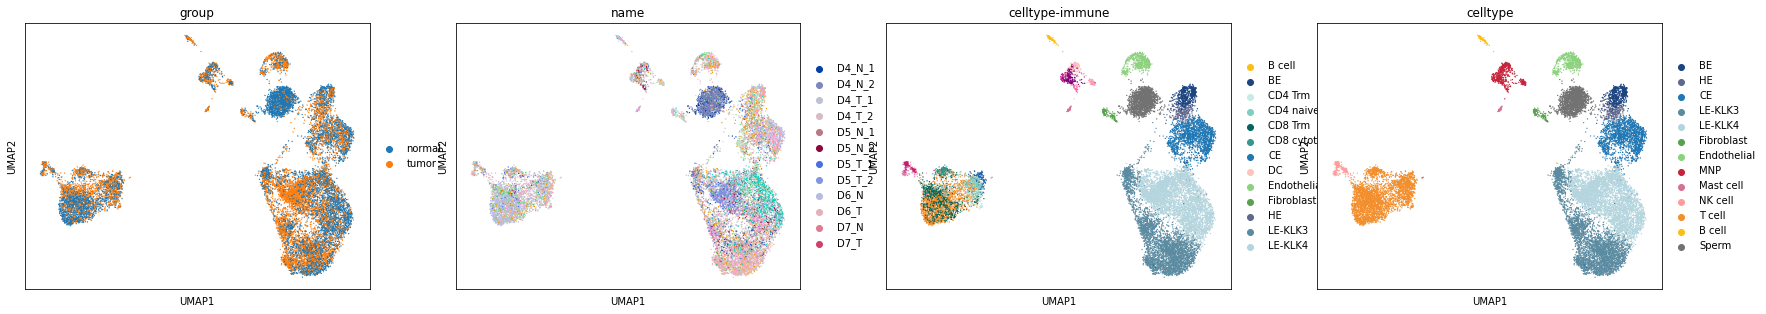

In [7]:
sc.pl.umap(data, color=['group', 'name', 'celltype-immune', 'celltype'])

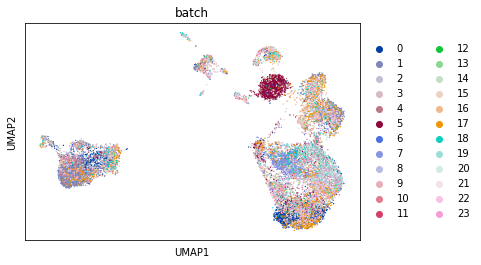

In [8]:
sc.pl.umap(data, color=['batch'])

## Let's try over-clustering and see if we converge on the original labels

In [18]:
?sc.tl.leiden

In [9]:
data.uns['neighbors']['params']

{'method': array(['umap'], dtype=object), 'n_neighbors': array([30])}

In [10]:
##### Remove sperm like in original publication...
print(data.shape)
data = data[data.obs['celltype'].values!='Sperm',:].copy()
data.shape

(17108, 33538)


(15492, 33538)

In [11]:
sc.pp.neighbors(data, n_neighbors=30)

In [12]:
sc.tl.leiden(data, resolution=4, key_added='overclustered', neighbors_key='neighbors')

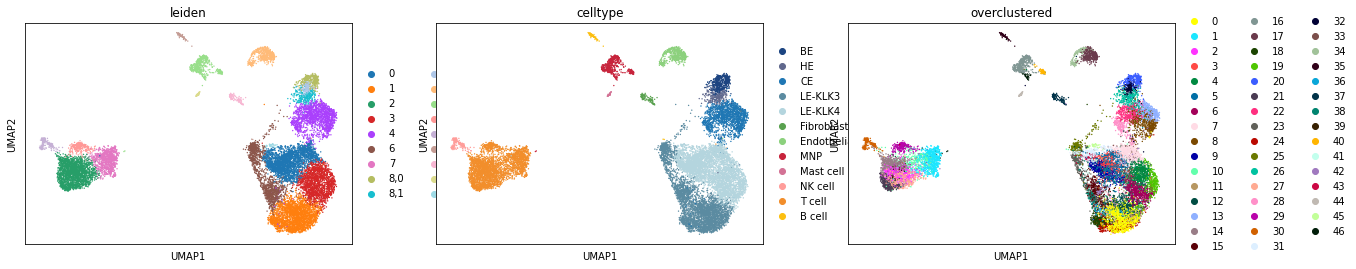

In [13]:
sc.pl.umap(data, color=['leiden', 'celltype', 'overclustered'])

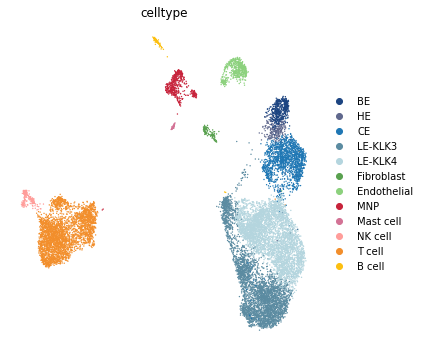

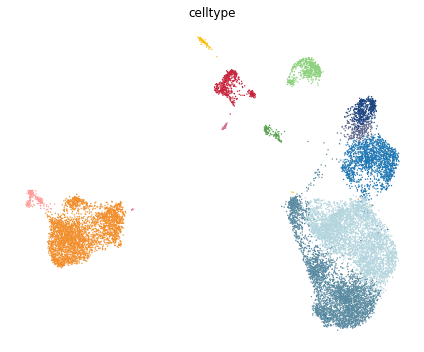

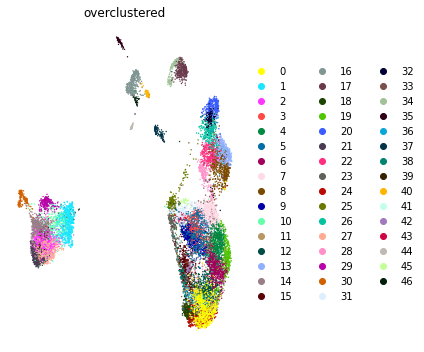

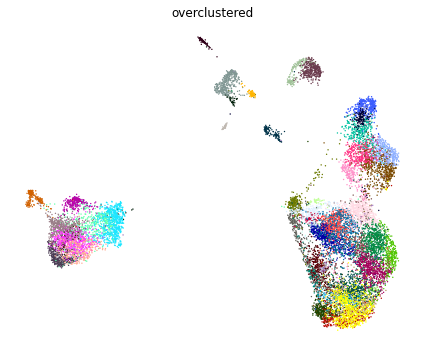

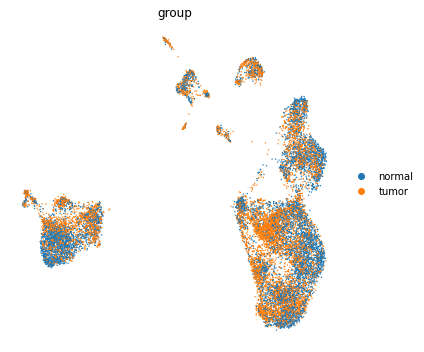

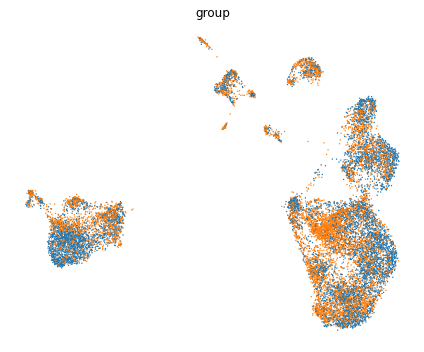

/home/s4392586/myPython/BeautifulCells/beautifulcells/visualisation/helpers.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


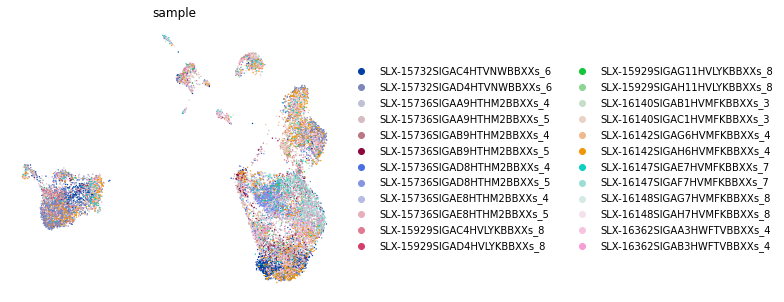

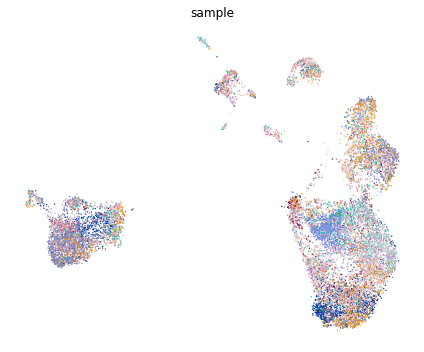

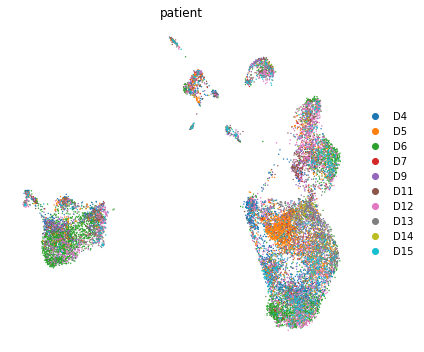

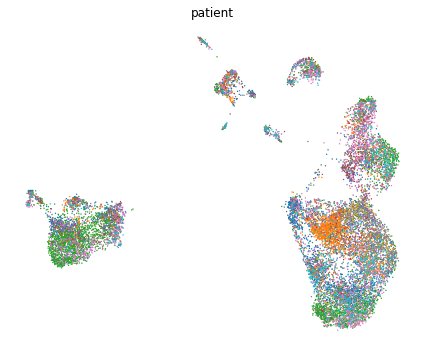

In [246]:
#### Saving these plots so can make figure
cols = ['celltype', 'overclustered', 'group', 'sample', 'patient']
for col in cols:
    fig, ax = plt.subplots(figsize=(6, 5))
    sc.pl.umap(data, color=[col], ax=ax, show=False, frameon=False, 
              )
    plt.show()
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sc.pl.umap(data, color=[col], ax=ax, legend_loc=None, show=False, frameon=False, 
              )
    plt.show()

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


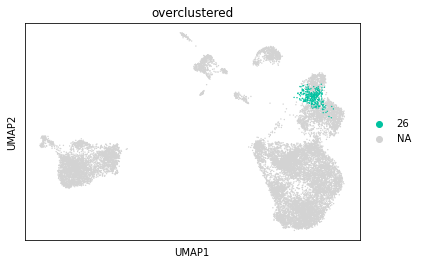

In [14]:
sc.pl.umap(data, color='overclustered', groups=['26'])

In [15]:
#### Get highly variable genes and remove mitochondrial/ribsomal from consideration...
sc.pp.highly_variable_genes(data, max_mean=5, min_disp=.01)
print(sum(data.var['highly_variable']))

10080


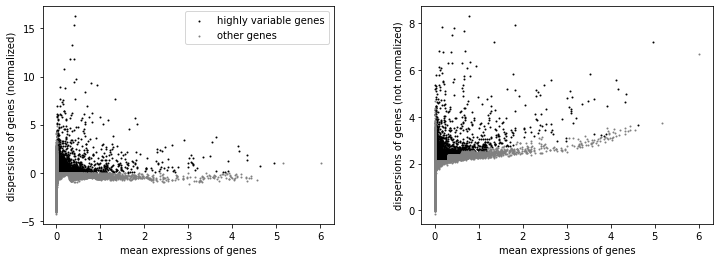

In [16]:
sc.pl.highly_variable_genes(data)

In [17]:
ribo_mito_genes = np.array([np.any([gene.startswith('MT-'), gene.startswith('RPL'), gene.startswith('RPS')])
                 for gene in data.var_names])
#data.var['highly_variable'] = np.logical_and(data.var['highly_variable'].values, ribo_mito_genes==False)
data.var['highly_variable'] = ribo_mito_genes==False
print(sum(data.var['highly_variable'].values))

33421


In [225]:
?cc.tl.get_markers

In [3]:
import cytocipher.score_and_merge.cluster_score as cs
import cytocipher.score_and_merge.cluster_merge as cm
imp.reload(cs)
imp.reload(cm)
imp.reload(cc.tl)

<module 'cytocipher.tl' from '/Users/uqbbalde/miniforge3/envs/cytocipher_ms/lib/python3.8/site-packages/cytocipher/tl.py'>

In [109]:
#### Code scoring...
cc.tl.get_markers(data, 'overclustered',
                 n_top=4, t_cutoff=14,
                 gene_order='logfc', min_de=1,
                 )

Added data.uns['overclustered_markers']


In [110]:
data.uns['overclustered_markers']

{'0': array(['MSMB', 'KLK3', 'AZGP1', 'ACPP'], dtype=object),
 '1': array(['LTB', 'CD52', 'TRAC', 'GPR183'], dtype=object),
 '2': array(['CCL5', 'MALAT1', 'CD52', 'CD69'], dtype=object),
 '3': array(['C15orf48', 'TRGC1', 'PCA3', 'FABP5'], dtype=object),
 '4': array(['MSMB', 'DBI', 'ADIRF', 'MIF'], dtype=object),
 '5': array(['TRGC1', 'PDLIM5', 'TRPM4', 'KLK4'], dtype=object),
 '6': array(['MSMB', 'CKB', 'PAK1IP1', 'DBI'], dtype=object),
 '7': array(['RPL17', 'RPLP0', 'RPL12', 'RPL36A'], dtype=object),
 '8': array(['CLDN4', 'ELF3', 'MGP', 'KLK11'], dtype=object),
 '9': array(['HPGD', 'LINC00668', 'FABP5', 'PCA3'], dtype=object),
 '10': array(['MALAT1', 'CCL5', 'BTG1', 'TMSB4X'], dtype=object),
 '11': array(['ACPP', 'IGFBP5', 'KLK3', 'RDH11'], dtype=object),
 '12': array(['ACPP', 'MSMB', 'KLK3', 'KLK2'], dtype=object),
 '13': array(['MGP', 'MMP7', 'KRT7', 'MAP1B'], dtype=object),
 '14': array(['CCL5', 'CD52', 'TRAC', 'CD3D'], dtype=object),
 '15': array(['KLK3', 'TFF3', 'OR51E2', 'GOLM1'

In [111]:
cc.tl.code_enrich(data, 'overclustered', n_cpus=15, squash_exception=True)

/home/s4392586/myPython/Cytocipher/cytocipher/score_and_merge/cluster_score.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all( np.unique(cluster_genes_dict[clusterj])==\


Full overlap of + and - gene sets detected for 12 and 24; suggested to increase number of marker genes for scoring.
Full overlap of + and - gene sets detected for 24 and 12; suggested to increase number of marker genes for scoring.
Added data.obsm['overclustered_enrich_scores']


/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:111: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)
/home/s4392586/myPython/BeautifulCells/beautifulcells/visualisation/helpers.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


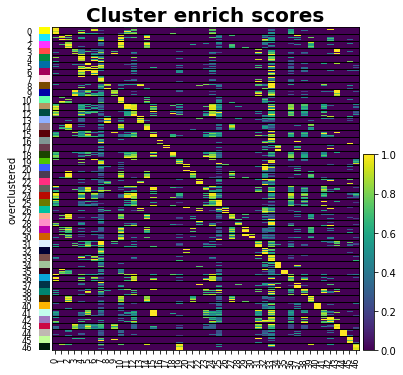

In [241]:
cc.pl.enrich_heatmap(data, 'overclustered', figsize=(6,6), show=False)
plt.show()

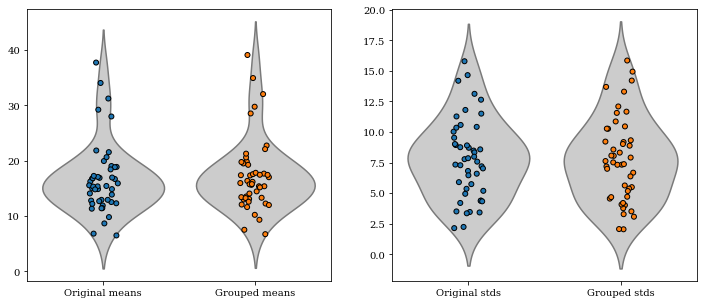

In [113]:
#### Check to make sure the grouping parameters don't distort statistics...
cc.pl.compare_stats_for_k(data, 'overclustered', k=30)

In [179]:
?cc.tl.merge_clusters

In [ ]:
#### Now let's call significant difference...
cc.tl.merge_clusters(data, 'overclustered', squash_exception=True, k=15, 
                     n_top_genes=4, t_cutoff=14,
                 gene_order='logfc', min_de=1,
                    )

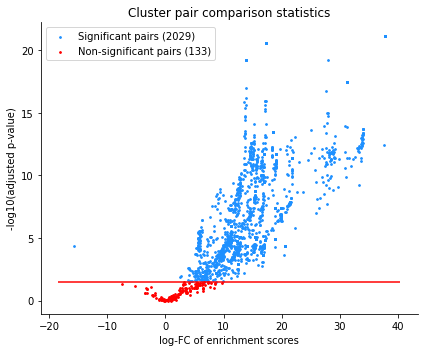

In [243]:
p_cut=.0325
cc.pl.volcano(data, 'overclustered', p_cut=p_cut, show=False)
plt.show()

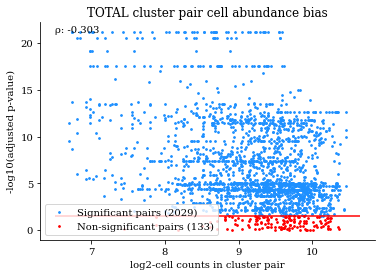

In [185]:
cc.pl.check_total_abundance_bias(data, 'overclustered', p_cut=p_cut)

In [186]:
#### Trying different settings for the p-value cutoff....
import cytocipher.score_and_merge.cluster_merge as cm

cm.merge(data, 'overclustered', p_cut, use_p_adjust=True)

Added data.uns['overclustered_mutualpairs']
Added data.obs['overclustered_merged']


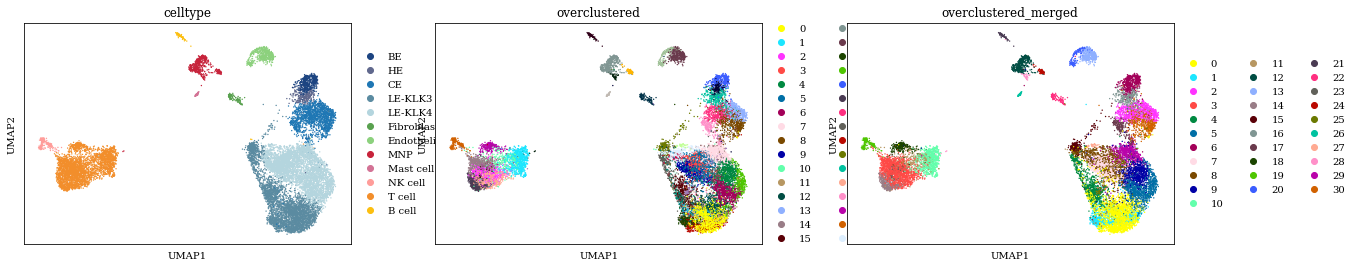

In [187]:
sc.pl.umap(data, color=['celltype', 'overclustered', 'overclustered_merged'])

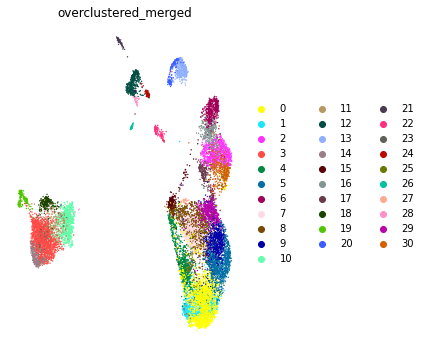

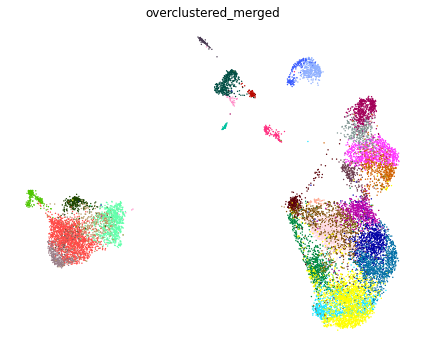

In [244]:
col = 'overclustered_merged'
fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.umap(data, color=[col], ax=ax, show=False, frameon=False, 
          )
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.umap(data, color=[col], ax=ax, legend_loc=None, show=False, frameon=False, 
          )
plt.show()

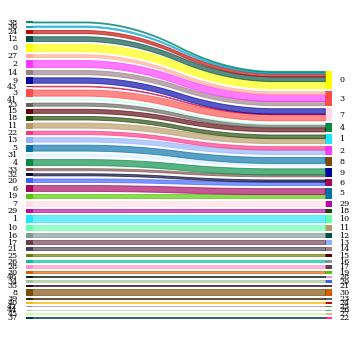

In [234]:
cc.pl.merge_sankey(data, 'overclustered')
plt.rc('font', family='sans-serif') # Switch back to default font

In [ ]:
cc.tl.get_markers(data, 'overclustered_merged', n_top=4, t_cutoff=14,
                 gene_order='logfc', min_de=1,
                  rerun_de=True,)
cc.tl.code_enrich(data, 'overclustered_merged', n_cpus=15, squash_exception=True)

/home/s4392586/myPython/Cytocipher/cytocipher/plotting/cluster_diagnostics.py:111: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  score_data = sc.AnnData(cell_scores_df, obs=data.obs)
/home/s4392586/myPython/BeautifulCells/beautifulcells/visualisation/helpers.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


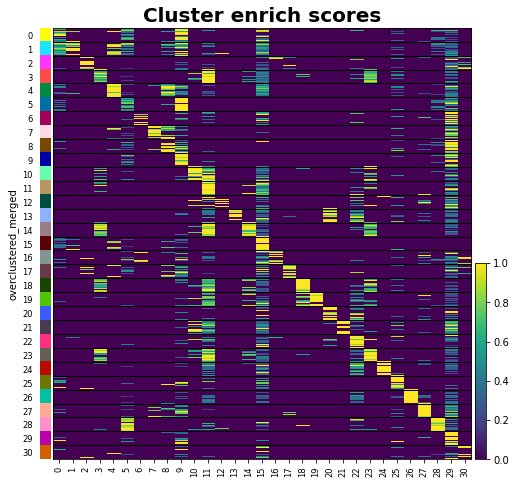

In [312]:
cc.pl.enrich_heatmap(data, 'overclustered_merged', per_cell=True, show=False)
plt.show()

In [191]:
data.uns['overclustered_merged_markers']

{'0': array(['MSMB', 'KLK3', 'ACPP', 'CD177'], dtype=object),
 '1': array(['ACPP', 'OR51E1', 'IGFBP5', 'KLK3'], dtype=object),
 '2': array(['MMP7', 'MGP', 'RARRES1', 'CP'], dtype=object),
 '3': array(['CCL5', 'CD52', 'CD3D', 'CD8A'], dtype=object),
 '4': array(['KLK3', 'OR51E2', 'GOLM1', 'TFF3'], dtype=object),
 '5': array(['MSMB', 'MT1G', 'MT2A', 'MT1X'], dtype=object),
 '6': array(['KRT15', 'KRT5', 'KRT17', 'S100A2'], dtype=object),
 '7': array(['LINC00668', 'PCA3', 'HPGD', 'FABP5'], dtype=object),
 '8': array(['TRGC1', 'TRPM4', 'PDLIM5', 'KLK4'], dtype=object),
 '9': array(['DBI', 'MSMB', 'ADIRF', 'MIF'], dtype=object),
 '10': array(['LTB', 'CD52', 'TRAC', 'GPR183'], dtype=object),
 '11': array(['MALAT1', 'CCL5', 'BTG1', 'TMSB4X'], dtype=object),
 '12': array(['C1QC', 'C1QA', 'C1QB', 'MS4A6A'], dtype=object),
 '13': array(['ACKR1', 'VWF', 'AQP1', 'SPARCL1'], dtype=object),
 '14': array(['CCL4L2', 'CCL4', 'IFNG', 'CCL5'], dtype=object),
 '15': array(['MT-ND3', 'MT-ND4', 'MT-CO1', 'MT

Input pair ('32', '26')
p=0.25423573405549704 (32 cells; 32 scores) vs (26 cells; 32 scores)
p=0.00960271369120816 (32 cells; 26 scores) vs (26 cells; 26 scores)


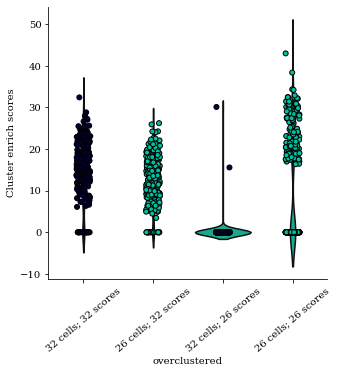

Input pair ('20', '26')
p=0.15899955551897557 (20 cells; 20 scores) vs (26 cells; 20 scores)
p=0.005159925588843325 (20 cells; 26 scores) vs (26 cells; 26 scores)


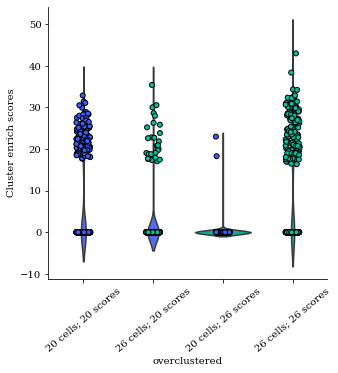

Input pair ('20', '32')
p=0.1054250247840825 (20 cells; 20 scores) vs (32 cells; 20 scores)
p=0.509338306053217 (20 cells; 32 scores) vs (32 cells; 32 scores)


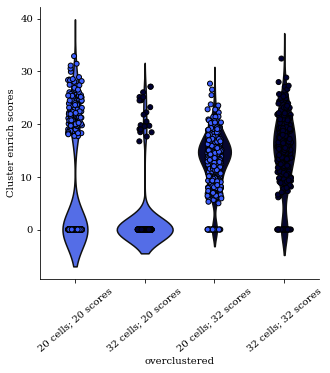

Input pair ('20', '8')
p=0.030126308201119955 (20 cells; 20 scores) vs (8 cells; 20 scores)
p=0.0373405774846475 (20 cells; 8 scores) vs (8 cells; 8 scores)


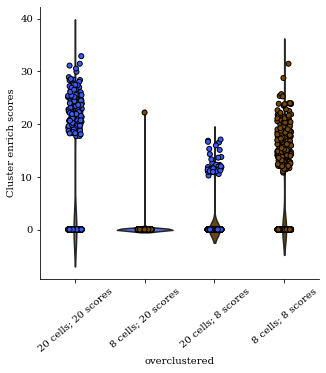

Input pair ('8', '32')
p=0.012112568298393881 (8 cells; 8 scores) vs (32 cells; 8 scores)
p=4.913535252420819e-05 (8 cells; 32 scores) vs (32 cells; 32 scores)


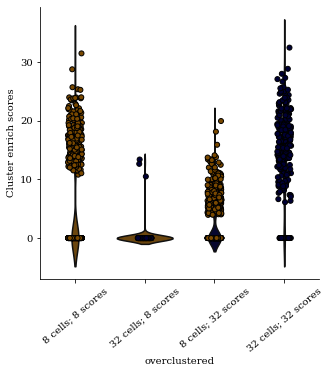

In [158]:
cc.pl.sig_cluster_diagnostics(data, 'overclustered', plot_pair=('32', '26'))
cc.pl.sig_cluster_diagnostics(data, 'overclustered', plot_pair=('20', '26'))
cc.pl.sig_cluster_diagnostics(data, 'overclustered', plot_pair=('20', '32'))
cc.pl.sig_cluster_diagnostics(data, 'overclustered', plot_pair=('20', '8'))
cc.pl.sig_cluster_diagnostics(data, 'overclustered', plot_pair=('8', '32'))

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


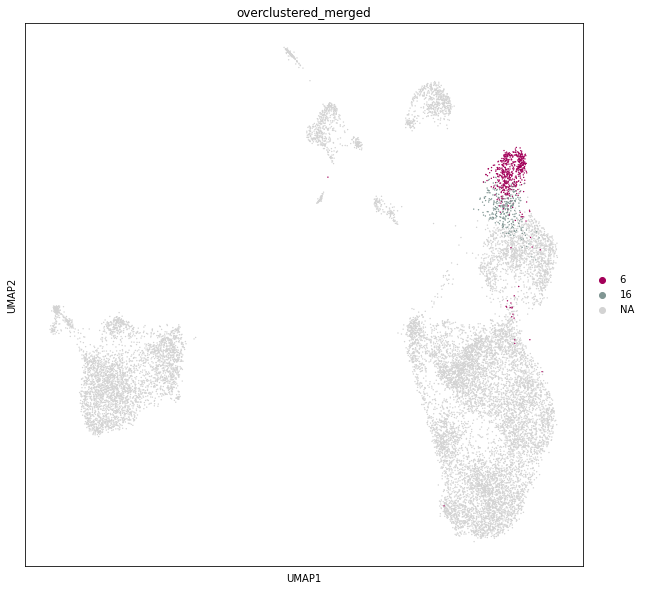

In [235]:
sc.pl.umap(data, color='overclustered_merged', groups=['6', '16'])

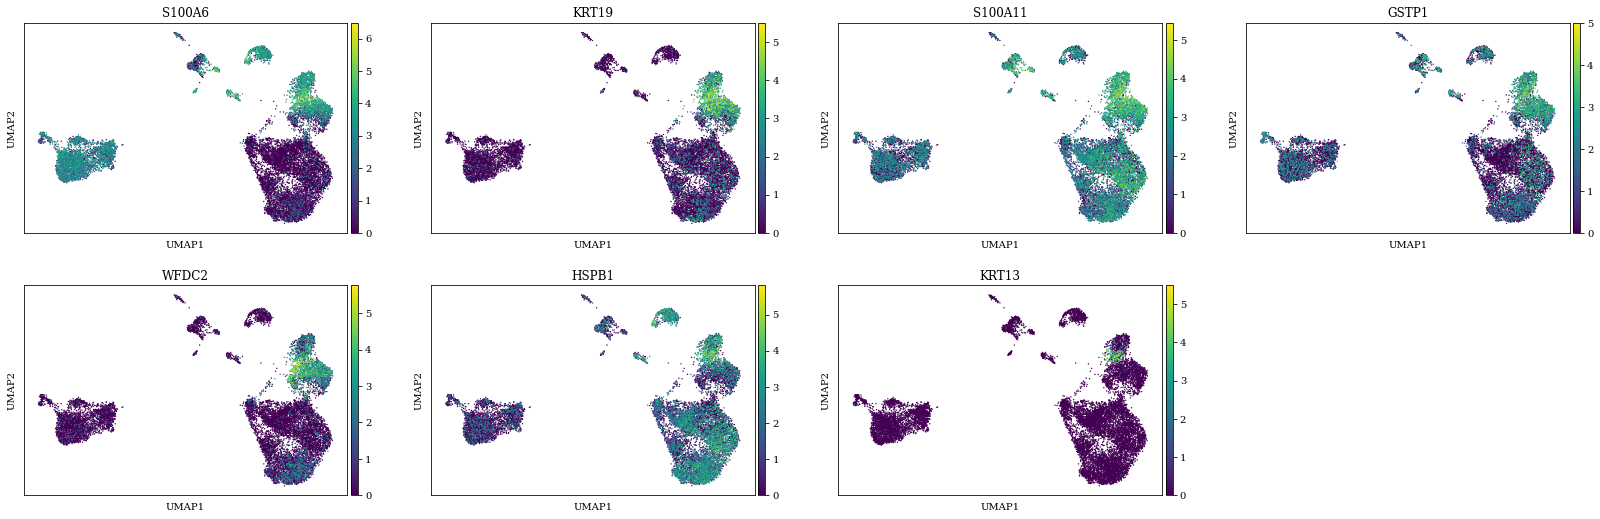

In [142]:
sc.pl.umap(data, color=['S100A6', 'KRT19', 'S100A11', 'GSTP1', 'WFDC2', 'HSPB1', 'KRT13'])

## Interpreting the results

For the purpose of focussing on cancer, let's focus on the new sub-divisions in the cancer cells...

In [196]:
data.obs.keys()

Index(['age', 'barcode', 'batch', 'group', 'highest_GLEASON_score',
       'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample',
       'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet',
       'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'celltype', 'Biopsy Location DETAIL', 'Biopsy Location BRIEF',
       'Biopsy Location Co-ordinate', 'PMHx', 'celltype-immune',
       'overclustered', 'overclustered_merged'],
      dtype='object')

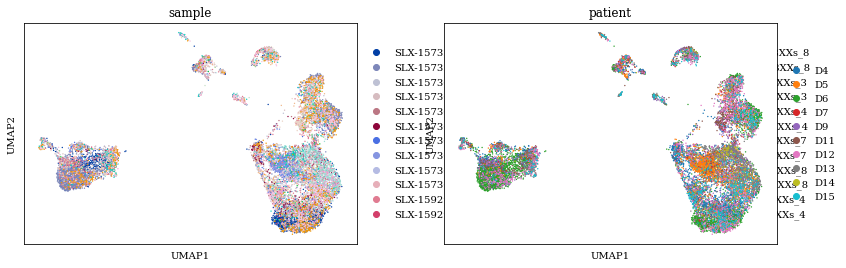

In [200]:
sc.pl.umap(data, color=['sample', 'patient'])

## Are any of the subtypes identified differentially represented in tumour/versus normal?

One way could do this, is to use Milo on the graph:
https://github.com/emdann/milopy

And see if this shows up with all cells of one of the new clusters being differentially abundant. 

Will follow tutorial here:
https://nbviewer.org/github/emdann/milopy/blob/master/notebooks/milopy_example.ipynb

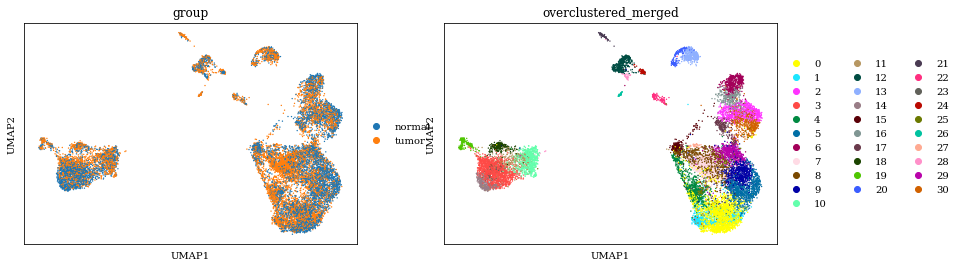

In [201]:
sc.pl.umap(data, color=['group', 'overclustered_merged'])

In [ ]:
!git clone https://github.com/emdann/milopy.git

### NOTE for the below to work, follow milopy install instructions: https://github.com/emdann/milopy

In [326]:
import sys
sys.path.append('./milopy/')

import milopy.core as milo
import milopy.plot as milopl

#NOTE milo has no version!

In [204]:
milo.make_nhoods(data, prop=0.1)

In [205]:
data.obsm["nhoods"]

<15492x1002 sparse matrix of type '<class 'numpy.float32'>'
	with 86724 stored elements in Compressed Sparse Row format>

In [206]:
data[data.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  \
index                                                             
SLX-15732SIGAC4HTVNWBBXXs_6_AAGGAGCCAATGTAAG                  1   
SLX-15732SIGAC4HTVNWBBXXs_6_ACACCAACACCCTATC                  1   
SLX-15732SIGAC4HTVNWBBXXs_6_ACACCGGCAATGACCT                  1   
SLX-15732SIGAC4HTVNWBBXXs_6_ACCCACTCAGATAATG                  1   
SLX-15732SIGAC4HTVNWBBXXs_6_ACGAGGAAGCCTATGT                  1   
...                                                         ...   
SLX-16362SIGAB3HWFTVBBXXs_4_ACTTGTTCATCACAAC                  1   
SLX-16362SIGAB3HWFTVBBXXs_4_GCGGGTTTCCGAGCCA                  1   
SLX-16362SIGAB3HWFTVBBXXs_4_TATTACCGTGGACGAT                  1   
SLX-16362SIGAB3HWFTVBBXXs_4_TGCGTGGCAAGACGTG                  1   
SLX-16362SIGAB3HWFTVBBXXs_4_TGGGCGTAGGCATTGG                  1   

                                              nhood_kth_distance  
index                                                             
SLX-15732SIGAC4HTVNWBBXXs_6_AAGGAGCCAATGTAAG            5.893317  
SLX-15732SIGAC4HTVNWBBXXs_6_ACACCAACACCCTATC            6.715589  
SLX-15732SIGAC4HTVNWBBXXs_6_ACACCGGCAATGACCT            6.371501  
SLX-15732SIGAC4HTVNWBBXXs_6_ACCCACTCAGATAATG            6.372472  
SLX-15732SIGAC4HTVNWBBXXs_6_ACGAGGAAGCCTATGT            5.810409  
...                                                          ...  
SLX-16362SIGAB3HWFTVBBXXs_4_ACTTGTTCATCACAAC            6.468517  
SLX-16362SIGAB3HWFTVBBXXs_4_GCGGGTTTCCGAGCCA            9.910761  
SLX-16362SIGAB3HWFTVBBXXs_4_TATTACCGTGGACGAT            6.092833  
SLX-16362SIGAB3HWFTVBBXXs_4_TGCGTGGCAAGACGTG            9.599901  
SLX-16362SIGAB3HWFTVBBXXs_4_TGGGCGTAGGCATTGG            6.125337  

[1002 rows x 2 columns]

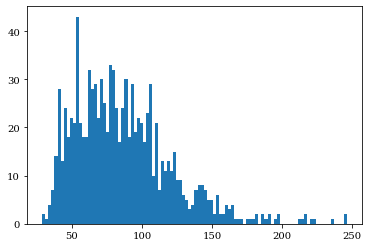

In [207]:
nhood_size = np.array(data.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [208]:
milo.count_nhoods(data, sample_col="sample")

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [209]:
data.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 1002 × 24
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [212]:
## Test for differential abundance between conditions
milo.DA_nhoods(data, design="~ group")

/home/s4392586/myPython/third_party/milopy/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [213]:
data.uns["nhood_adata"].obs

index_cell  kth_distance     logFC  \
0     SLX-15732SIGAC4HTVNWBBXXs_6_AAGGAGCCAATGTAAG      5.893317  5.172898   
1     SLX-15732SIGAC4HTVNWBBXXs_6_ACACCAACACCCTATC      6.715589  3.259833   
2     SLX-15732SIGAC4HTVNWBBXXs_6_ACACCGGCAATGACCT      6.371501  5.454527   
3     SLX-15732SIGAC4HTVNWBBXXs_6_ACCCACTCAGATAATG      6.372472  1.904049   
4     SLX-15732SIGAC4HTVNWBBXXs_6_ACGAGGAAGCCTATGT      5.810409  5.703087   
...                                            ...           ...       ...   
997   SLX-16362SIGAB3HWFTVBBXXs_4_ACTTGTTCATCACAAC      6.468517 -1.171902   
998   SLX-16362SIGAB3HWFTVBBXXs_4_GCGGGTTTCCGAGCCA      9.910761 -3.514219   
999   SLX-16362SIGAB3HWFTVBBXXs_4_TATTACCGTGGACGAT      6.092833 -0.966173   
1000  SLX-16362SIGAB3HWFTVBBXXs_4_TGCGTGGCAAGACGTG      9.599901 -3.471984   
1001  SLX-16362SIGAB3HWFTVBBXXs_4_TGGGCGTAGGCATTGG      6.125337 -1.619535   

         logCPM          F    PValue       FDR  SpatialFDR  
0     11.030448  15.613627  0.000262  0.010652    0.008702  
1     10.692757   6.770398  0.012386  0.089934    0.077409  
2     10.831239  14.264169  0.000582  0.010652    0.008948  
3     10.853436   3.177039  0.081197  0.319058    0.297235  
4     10.982204  14.546694  0.000523  0.010652    0.008948  
...         ...        ...       ...       ...         ...  
997   10.961980   1.785799  0.187756  0.521141    0.504507  
998   10.353116  10.005757  0.002746  0.031883    0.026879  
999   10.548632   0.940813  0.337031  0.694866    0.692243  
1000  10.432756  10.419130  0.002278  0.029293    0.024528  
1001  10.550558   2.400602  0.128056  0.436147    0.413222  

[1002 rows x 8 columns]

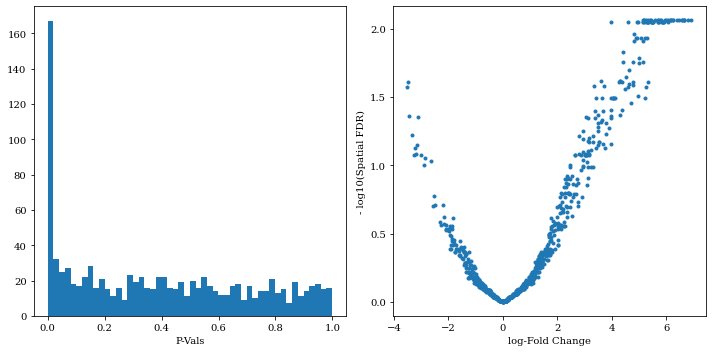

In [214]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(data.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(data.uns["nhood_adata"].obs.logFC, -np.log10(data.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [252]:
data.uns["nhood_adata"].obs.keys()

Index(['index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR',
       'SpatialFDR', 'Nhood_size', 'nhood_annotation',
       'nhood_annotation_frac'],
      dtype='object')

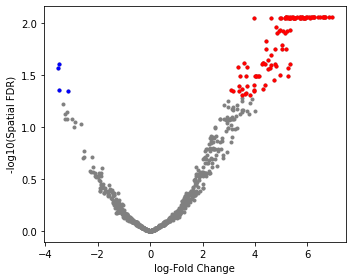

In [316]:
##### Making a nice violin for DA analysis
sig_bool = data.uns["nhood_adata"].obs.SpatialFDR.values < .05
sig_up = np.logical_and(sig_bool, data.uns["nhood_adata"].obs.logFC.values>0 )
sig_down = np.logical_and(sig_bool, data.uns["nhood_adata"].obs.logFC.values<0 )
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(data.uns["nhood_adata"].obs.logFC, -np.log10(data.uns["nhood_adata"].obs.SpatialFDR), '.',
       color='grey');
ax.plot(data.uns["nhood_adata"].obs.logFC.values[sig_up], 
        -np.log10(data.uns["nhood_adata"].obs.SpatialFDR.values[sig_up]), '.',
       color='red');
ax.plot(data.uns["nhood_adata"].obs.logFC.values[sig_down], 
        -np.log10(data.uns["nhood_adata"].obs.SpatialFDR.values[sig_down]), '.',
       color='blue');
ax.set_xlabel("log-Fold Change");
ax.set_ylabel("-log10(Spatial FDR)");
#ax.set_xlim((-6.5,6.5))
plt.tight_layout()
plt.show()

In [215]:
import milopy.utils
milopy.utils.build_nhood_graph(data)

In [229]:
-np.log10(.05)

1.3010299956639813

In [261]:
?milopl.plot_nhood_graph

In [257]:
?sc.pl.embedding

In [262]:
imp.reload(milopl)

<module 'milopy.plot' from '/home/s4392586/myPython/third_party/milopy/milopy/plot.py'>

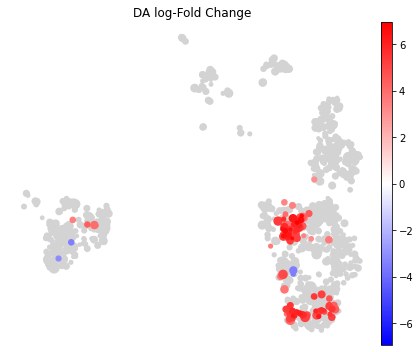

In [289]:
plt.rcParams["figure.figsize"] = [10,10]
fig, ax = plt.subplots(figsize=(6,5))
milopl.plot_nhood_graph(data, 
                        alpha=0.05, ## SpatialFDR level (1%) 
                        min_size=2, ## Size of smallest dot
                        cmap='bwr',
                        ax=ax, show=False
                       )
plt.show()

In [271]:
milopy.utils.annotate_nhoods(data, anno_col='overclustered_merged')

In [276]:
data.uns['nhood_adata'].uns['nhood_annotation_colors'] = data.uns['overclustered_merged_colors']

In [279]:
data.uns['nhood_adata'].obs.keys()

Index(['index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR',
       'SpatialFDR', 'Nhood_size', 'nhood_annotation',
       'nhood_annotation_frac'],
      dtype='object')

In [284]:
data.uns['nhood_adata'].obs["-log10(Spatial FDR)"] = -np.log10(data.uns["nhood_adata"].obs.SpatialFDR)

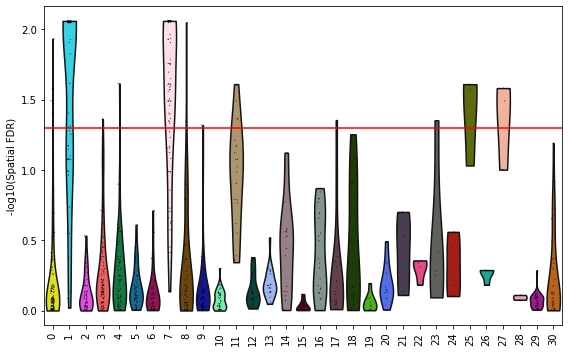

In [290]:
fig, ax = plt.subplots(figsize=(8,5))
sc.pl.violin(data.uns['nhood_adata'], "-log10(Spatial FDR)", #"logFC", 
             groupby="nhood_annotation", rotation=90, show=False, ax=ax);
plt.axhline(y=-np.log10(.05), color='red', linestyle='-');
plt.show()

/opt/miniconda/miniconda3/envs/hypo_atlas4/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


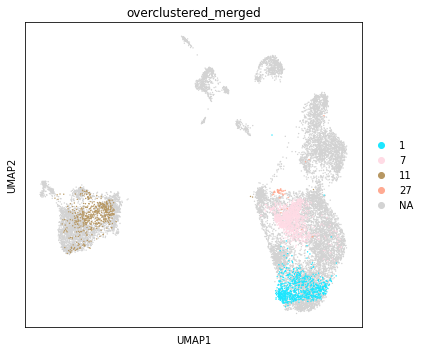

In [291]:
cois = ['1', '7', '11', '27']
fig, ax = plt.subplots(figsize=(6,5))
sc.pl.umap(data, color='overclustered_merged', groups=cois, ax=ax, show=False)
plt.show()

In [292]:
#### Now let's try with the original annotations..
milopy.utils.annotate_nhoods(data, anno_col='celltype')

In [293]:
data.uns['nhood_adata'].uns['nhood_annotation_colors'] = data.uns['celltype_colors']

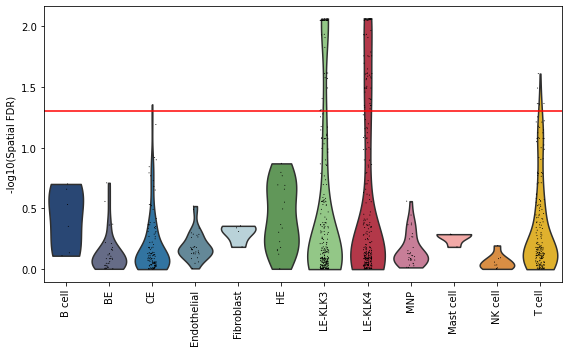

In [307]:
fig, ax = plt.subplots(figsize=(8,5))
sc.pl.violin(data.uns['nhood_adata'], "-log10(Spatial FDR)", #"logFC", 
             groupby="nhood_annotation", rotation=90, show=False, ax=ax);
plt.axhline(y=-np.log10(.05), color='red', linestyle='-');
plt.show()

In [295]:
{clust: data.uns['overclustered_merged_markers'][clust] for clust in cois}

{'1': array(['ACPP', 'OR51E1', 'IGFBP5', 'KLK3'], dtype=object),
 '7': array(['LINC00668', 'PCA3', 'HPGD', 'FABP5'], dtype=object),
 '11': array(['MALAT1', 'CCL5', 'BTG1', 'TMSB4X'], dtype=object),
 '27': array(['STMN1', 'TUBA1B', 'H2AFZ', 'HMGN2'], dtype=object)}

## This is looking amazing! These genes make a ton of sense:

- STMN1: Oncoprotein that regulates cell proliferation, commonly overexpressed in aggressive prostate cancers https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5897228/#:~:text=In%20aggressive%20prostate%20cancers%2C%20the,%2C%20motility%2C%20and%20tumor%20metastasis.
- CCL5: Regulates interactions between T cells and pancreatic cancer cells!!! 
https://pubmed.ncbi.nlm.nih.gov/35917973/
- PCA3: A key urine marker for prostate cancer!!!
- HPGD: Also implicated as important metabolism related gene in pancreatic cancer: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3253723/
- FABP5: Also important metabolic regulator in pancreatic cancer:
https://www.oncotarget.com/article/25878/text/
- ACPP: A key regulator of tumour suppresion, particular in pancreatic cancer:
https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-2787-y#Bib1
- IGFBP5: Known roles in pancreas cancer development:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7281733/

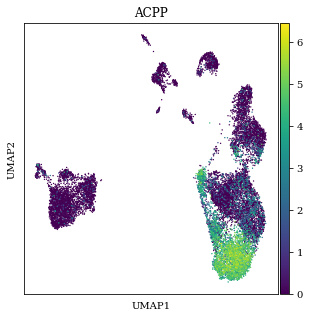

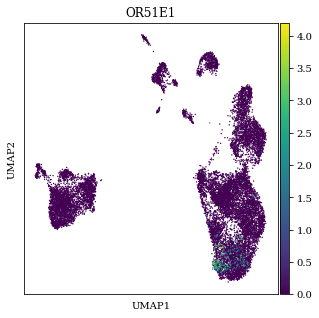

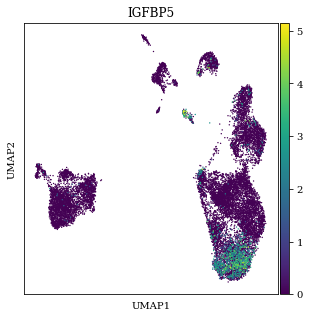

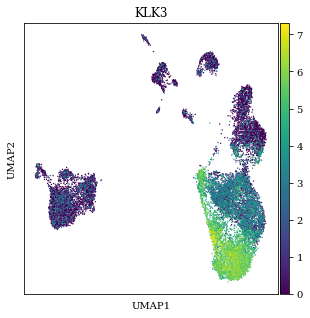

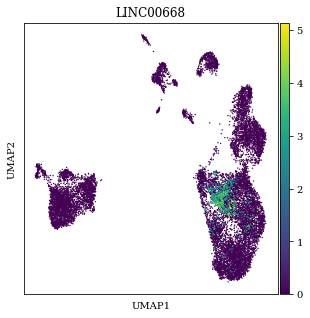

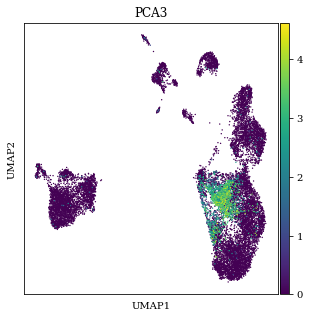

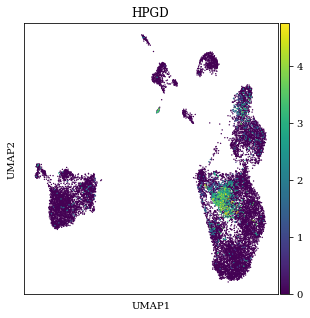

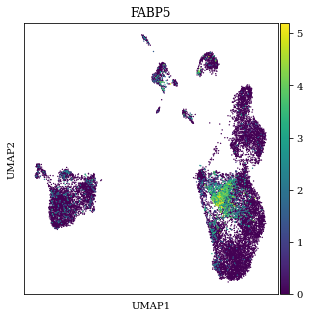

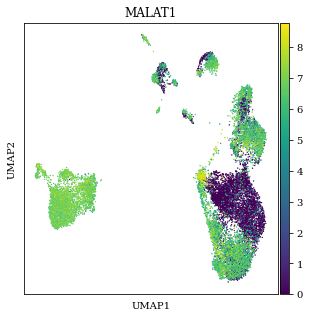

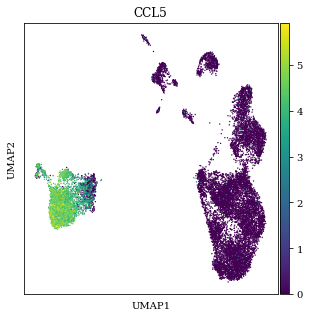

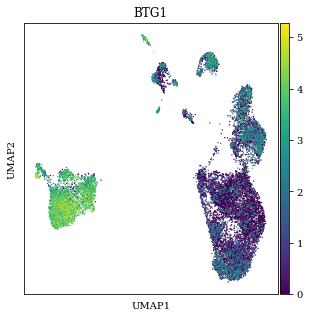

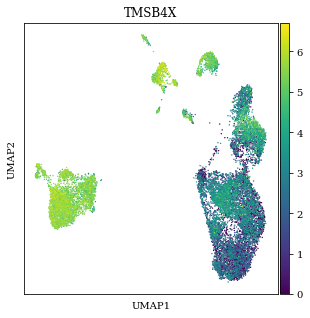

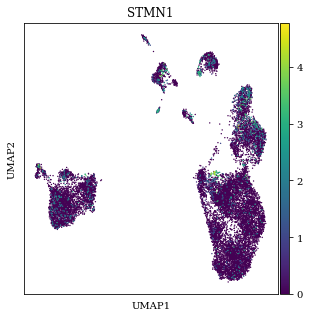

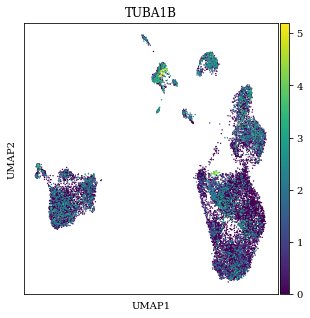

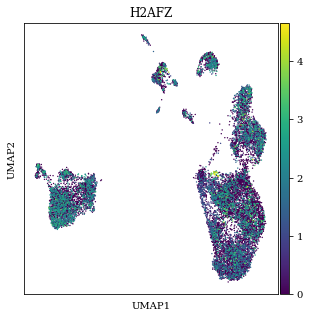

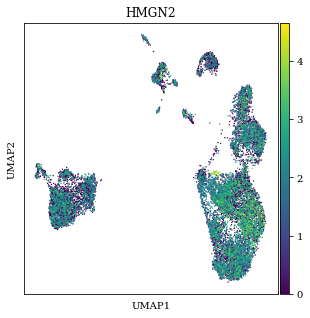

In [232]:
gois = []
[gois.extend(data.uns['overclustered_merged_markers'][clust]) for clust in cois]

for gene in gois:
    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.umap(data, color=gene, ax=ax)

In [296]:
data.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap, overclustered_enrich_scores, overclustered_merged_enrich_scores, nhoods)

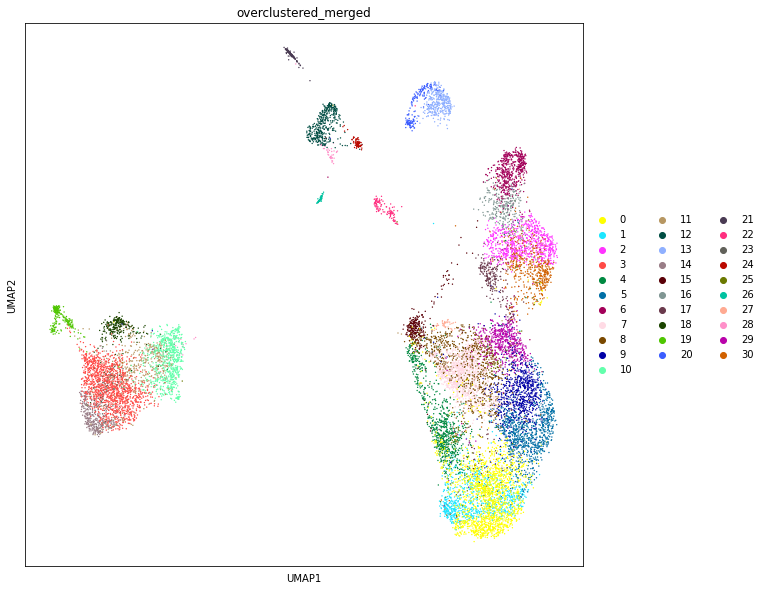

In [298]:
sc.pl.umap(data, color='overclustered_merged')

In [309]:
out_plots

'plots/coexpr_score/cancer/'

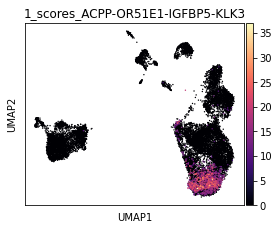

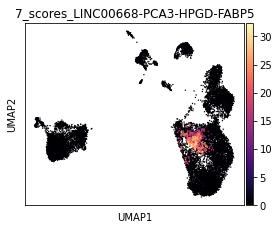

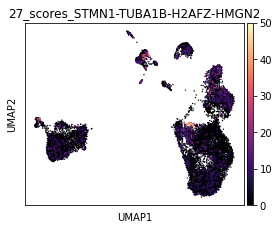

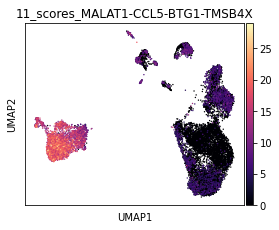

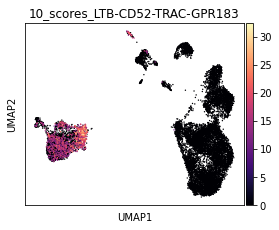

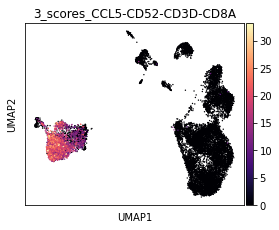

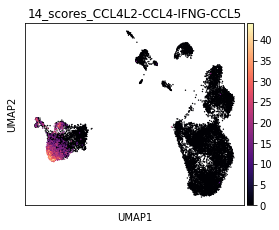

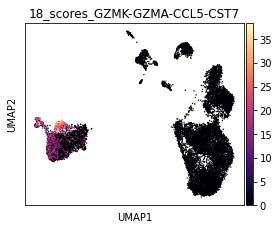

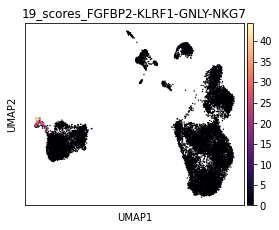

In [319]:
### For the clusters of interest, let's visualise the enrichment scores with code-scoring versus coexpr scoring...
enrich_scores = data.obsm['overclustered_merged_enrich_scores']

#### Need to plot other t-cells clusters too...
cois = ['1', '7', '27', '11', 
        '10', '3', '14', '18', '19']
for clust in cois:
    marker_str = '-'.join(data.uns['overclustered_merged_markers'][clust])
    score_col = f'{clust}_scores_{marker_str}'
    data.obs[score_col] = enrich_scores[clust].values
    
    fig, ax = plt.subplots(figsize=(4,3.3))
    vmax = None if clust!='27' else 50
    sc.pl.umap(data, color=score_col, ax=ax, cmap='magma', vmax=vmax, show=False)
    plt.show()

In [310]:
data.shape

(15492, 33538)